In [360]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [361]:
df = pd.read_csv("df_weekly_pm.csv")
df = df.set_index('Date')
df_train, df_test = df[:"2020-01-01"], df["2020-01-01":]

(                PM2.5
 Date                 
 2020-05-03  43.191429
 2020-05-10  46.700000
 2020-05-17  62.765714
 2020-05-24  79.432857
 2020-05-31  38.335714
 2020-06-07  46.195714
 2020-06-14  58.957143
 2020-06-21  41.858571
 2020-06-28  41.014286
 2020-07-05  46.223333,
                 PM2.5
 Date                 
 2020-05-03  79.432857
 2020-05-10  38.335714
 2020-05-17  46.195714
 2020-05-24  58.957143
 2020-05-31  41.858571
 2020-06-07  41.014286
 2020-06-14  46.223333
 2020-06-21        NaN
 2020-06-28        NaN
 2020-07-05        NaN)

In [364]:
def get_ml_data(train, feature_len):
    train_arr = np.asarray(train)
    train_shift = np.asarray(train.shift(-feature_len))
    train_x, train_y = [], []
    for i in range(len(train_arr) - feature_len):
        train_x.append(train_arr[i:i+])
        train_y.append(train_shift[i])
    return np.asarray(train_x), np.asarray(train_y)

In [365]:
feature_len=60
train_x, train_y = get_ml_data(df_train, feature_len)

In [366]:
train_x = train_x.reshape(201, 60)
train_y = train_y.reshape(201)
train_x.shape, train_y.shape

((201, 60), (201,))

In [354]:
regr = MLPRegressor(hidden_layer_sizes = (90, 10), max_iter=1000, random_state=1).fit(train_x, train_y)

In [367]:
test_pred = []
train = np.asarray(df_train).reshape(261,)

for i in range(len(df_test)):
    if i > 0:
        x = np.asarray(list(train[-feature_len + i:,]) + list(test_pred)).reshape(1, feature_len)
    else:
        x = np.asarray(train[-feature_len + i:,]).reshape(1, feature_len)
    pred = regr.predict(x)
    test_pred.append(pred)
test_pred = np.asarray(test_pred)
test_pred, test_pred.shape

(array([[187.86138998],
        [192.25096559],
        [173.19955118],
        [148.62039225],
        [137.99572455],
        [132.20659524],
        [134.35498186],
        [107.79043061],
        [100.42457499],
        [ 77.29001176],
        [ 61.7597378 ],
        [ 89.17767221],
        [ 65.58012027],
        [ 75.27075942],
        [ 65.43715318],
        [ 62.45939252],
        [ 76.93639268],
        [ 72.72118912],
        [ 93.30842127],
        [ 85.61409606],
        [ 83.65464948],
        [ 85.84004051],
        [ 64.12876649],
        [ 64.28789785],
        [ 49.56600093],
        [ 35.68035327],
        [ 51.55274359]]),
 (27, 1))

In [368]:
pred_y = test_pred
test_y = np.array(df_test)
evaluation_results = pd.DataFrame({'r2_score': r2_score(test_y, pred_y)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test_y, pred_y)
evaluation_results['mean_squared_error'] = np.sqrt(mean_squared_error(test_y, pred_y))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(pred_y - test_y)/np.abs(test_y))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.700849,21.572828,28.857262,34.203954


In [369]:
pred_train = regr.predict(train_x)
train_y = np.array(train_y)
evaluation_results = pd.DataFrame({'r2_score': r2_score(train_y, pred_train)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(train_y, pred_train)
evaluation_results['mean_squared_error'] = np.sqrt(mean_squared_error(train_y, pred_train))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(pred_train - train_y)/np.abs(train_y))*100 
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.691048,24.957306,43.413543,22.427944


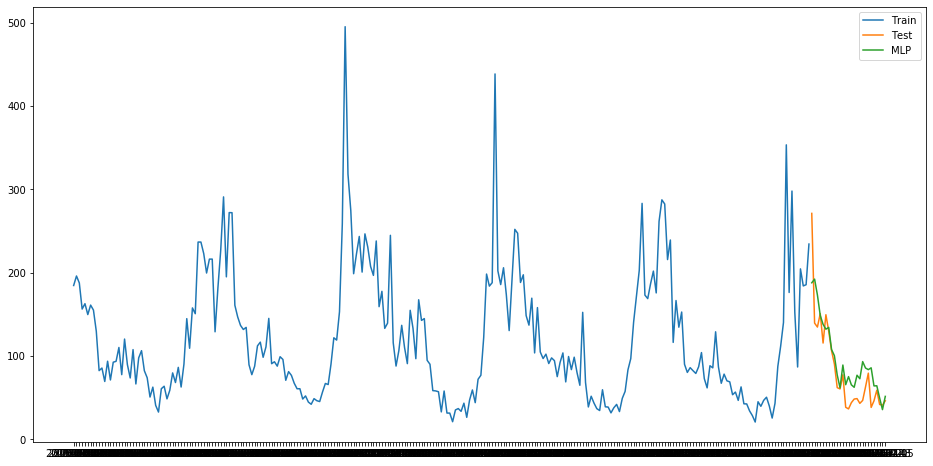

In [370]:
train = df_train
test = df_test
y_hat_avg = test.copy()
y_hat_avg['MLP'] = pred_y
plt.figure(figsize=(16,8))
plt.plot( train['PM2.5'], label='Train')
plt.plot(test['PM2.5'], label='Test')
plt.plot(y_hat_avg['MLP'], label='MLP')
plt.legend(loc='best')
plt.savefig('images/pm-mlp-forecast.png')
plt.show()